# Simple Montecarlo Example

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
def all_vals(run, name):
    vs = []
    for st in run.getsteps():
        v = run.step(st).get_tensor(name).as_numpy()
        vs.append(v)
    return np.array(vs)

This notebook will show how to run Montecarlo to capture the inputs/outputs/intermediate layers of an inference run and compare it with the corresponding data from the training run

## Train a Simple Model

This very simple model learns the coefficients of a simple linear equation: `y_hat=Wx+b`. The data we feed to it follows the formula `y=5x+1`, so we should converge to `W==5` and `b==1`

In [3]:
!rm -rf ts_outputs/train
!rm -rf model
!python ./simplemodel_train.py --mean 0 --stddev 2 --batchsize 256 --epochs 1000

2019-04-18 10:16:31.355871: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Epoch: 0001 cost= 6721.340820312 W= 2.3675923 b= 0.8477539
Epoch: 0101 cost= 123.101486206 W= 4.668736 b= 0.8997093
Epoch: 0201 cost= 2.549396992 W= 4.958542 b= 0.94027495
Epoch: 0301 cost= 0.329603940 W= 4.994855 b= 0.9643348
Epoch: 0401 cost= 0.118118107 W= 4.999462 b= 0.9786624
Epoch: 0501 cost= 0.041727878 W= 4.9999423 b= 0.9872289
Epoch: 0601 cost= 0.014956966 W= 4.999992 b= 0.9923562
Epoch: 0701 cost= 0.005347713 W= 5.000022 b= 0.9954251
Epoch: 0801 cost= 0.001918845 W= 4.9999933 b= 0.9972619
Epoch: 0901 cost= 0.000687572 W= 4.9999895 b= 0.9983698
Optimization Finished!
Training cost= 0.00024611675 W= 5.0000043 b= 0.9990243


This will deposit a model in `./model`

In [4]:
!ls -l ./model/

total 48
-rw-r--r--  1 olg  ANT\Domain Users     67 Apr 18 10:16 checkpoint
-rw-r--r--  1 olg  ANT\Domain Users      8 Apr 18 10:16 model.data-00000-of-00001
-rw-r--r--  1 olg  ANT\Domain Users    142 Apr 18 10:16 model.index
-rw-r--r--  1 olg  ANT\Domain Users  35877 Apr 18 10:16 model.meta


And will deposit the Tornasole/Montecarlo data in `./ts_output/train/`


In [5]:
!ls -l ./ts_outputs/train/

total 0
drwxr-xr-x  104 olg  ANT\Domain Users  3328 Apr 18 10:16 ecffef59-f2df-48e9-ae52-f81671adb1f2


## Run Inference on the Trained Model

Now we load the model we previously deposited in `./model` and run inference. The Tornasole/Montecarlo traces will be deposited in `./ts_output/infer`. We only trace three tensors: `X:0` (the input), `product:0` (an intermediate result), `Y_hat:0` (the output).

Let's pretend we have a run with inputs having a different statistical distribution from the training data: `mean=3`, `stddev=6`. We also choose a batch size of 17 (just because) and run for 1000 steps, evaluating a total of 17,000 input samples.

In [37]:
!rm -rf ts_outputs/infer
!python simplemodel_infer.py --mean 3 --stddev 6 --batchsize 17 --steps 1000

2019-04-18 10:36:37.808473: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Running sample 0
Running sample 100
Running sample 200
Running sample 300
Running sample 400
Running sample 500
Running sample 600
Running sample 700
Running sample 800
Running sample 900


The output of the Montecarlo trace is deposited in `ts_outputs/infer/`. Each directory shown below contains the trace for a single batch (of size==17, in this case)

In [34]:
!ls -l ./ts_outputs/infer/*/ | head

total 0
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 0
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 1
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 10
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 100
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 101
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 102
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 103
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 104
drwxr-xr-x  3 olg  ANT\Domain Users  96 Apr 18 10:35 105


## Running MonteCarlo

Now we have traces for a single training run, which ran for multiple batches, in `./ts_outputs/train/`, and a single inference run, which ran for 1000 batches of size==17, in `./ts_outputs/infer/`. 

Let's say that we want to compare the distribution of inputs, intermediate results, and outputs.

In [21]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from tornasole_rules.run_catalog import LocalRunCatalog
from tornasole_rules.run import LocalRun

tdir = "./ts_outputs/train"
idir = "./ts_outputs/infer"

# We scan the disc to find the training run
training_run_catalog = LocalRunCatalog(tdir)
inference_run_catalog = LocalRunCatalog(idir)


First we ask Montecarlo to list all the training runs it knows something about

In [22]:
training_run_names = training_run_catalog.list_candidates()
for training_run_name in training_run_names:
    print( f'Training Run {training_run_name}')
    tr = LocalRun(training_run_name, os.path.join(tdir,training_run_name))

Training Run ecffef59-f2df-48e9-ae52-f81671adb1f2
None


Then all the inference runs it knows about. In the SageMaker world, a single endpoint would constitute a Run

In [55]:
inference_run_names = inference_run_catalog.list_candidates()
for inference_run_name in inference_run_names:
    print( f'Inference Run {inference_run_name}')
    ir = LocalRun(inference_run_name, os.path.join(idir,inference_run_name))


Inference Run 42cbf42b-b2c1-46eb-86a4-9d8d64549b21
None


We can plot the input distributions of the tensor called `X:0` (the input), respectively in the training and inference runs

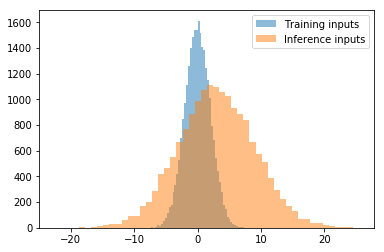

In [57]:
xs_train = all_vals(tr,"X:0").flatten()
xs_infer = all_vals(ir,"X:0").flatten()
plt.hist(xs_train, bins=50, alpha=0.5, label="Training inputs")
plt.hist(xs_infer, bins=50, alpha=0.5, label="Inference inputs")
plt.legend()
plt.show()

We can also look at values _inside_, say a tensor named `product:0`. Again, note the difference between training and inference.

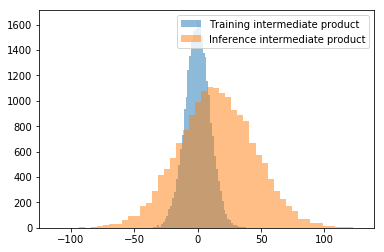

In [58]:
product_train = all_vals(tr, "product:0").flatten()
product_infer = all_vals(ir, "product:0").flatten()

plt.hist(product_train, bins=50, alpha=0.5, label="Training intermediate product")
plt.hist(product_infer, bins=50, alpha=0.5, label="Inference intermediate product")
plt.legend()
plt.show()

And finally, the outputs:
- training (actual): `Y:0`
- training (predicted): `Y_hat:0`
- inference (predicted): `Y_hat:0`

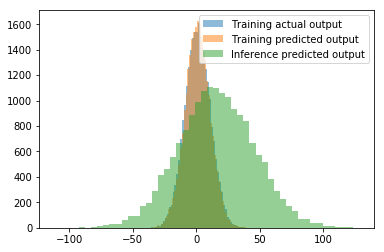

In [59]:
output_actual_train = all_vals(tr, "Y:0").flatten()
output_predicted_train = all_vals(tr, "Y_hat:0").flatten()
output_predicted_infer = all_vals(ir, "Y_hat:0").flatten()


plt.hist(output_actual_train, bins=50, alpha=0.5, label="Training actual output")
plt.hist(output_predicted_train, bins=50, alpha=0.5, label="Training predicted output")
plt.hist(output_predicted_infer, bins=50, alpha=0.5, label="Inference predicted output")
plt.legend()
plt.show()